<a href="https://colab.research.google.com/github/Mikhail-Klochkov/ml_intro/blob/master/nlp_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import string
import operator

from collections import defaultdict

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from wordcloud import STOPWORDS

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip '/content/drive/MyDrive/Colab_Notebooks/nlp.zip' -d data


Archive:  /content/drive/MyDrive/Colab_Notebooks/nlp.zip
   creating: data/nlp/
  inflating: data/__MACOSX/._nlp     
  inflating: data/nlp/positive-words.txt  
  inflating: data/__MACOSX/nlp/._positive-words.txt  
  inflating: data/nlp/sample submission.csv  
  inflating: data/__MACOSX/nlp/._sample submission.csv  
  inflating: data/nlp/SentiWordNet.txt  
  inflating: data/__MACOSX/nlp/._SentiWordNet.txt  
  inflating: data/nlp/test.csv       
  inflating: data/__MACOSX/nlp/._test.csv  
  inflating: data/nlp/train.csv      
  inflating: data/__MACOSX/nlp/._train.csv  
  inflating: data/nlp/negative-words.txt  
  inflating: data/__MACOSX/nlp/._negative-words.txt  


In [119]:
df = pd.read_csv("/content/data/nlp/train.csv", encoding='ISO-8859-1')
df_new = df.copy(deep = True)

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2351 entries, 0 to 2350
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Id            2351 non-null   int64  
 1   Hotel_name    2351 non-null   object 
 2   Review_Title  2136 non-null   object 
 3   Review_Text   2351 non-null   object 
 4   Rating        2351 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 92.0+ KB


In [121]:
if('Id' in set(df.columns)):
  df.drop(columns= ['Id'], inplace = True)

Пропущенные значения у Review_Title

In [122]:
df.isna().sum(axis = 0)

Hotel_name        0
Review_Title    215
Review_Text       0
Rating            0
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


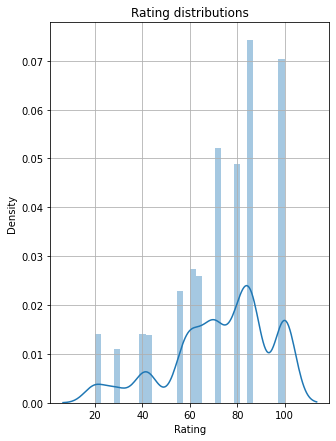

In [123]:
fig, ax = plt.subplots(figsize = (5, 7))
sns.distplot(a = df.Rating, 
             bins = 30, 
             hist = True, 
             ax = ax,
             label = 'Rating')
ax.set_title('Rating distributions')
ax.grid()

In [124]:

print('We have several levels of rating : {}\nsize of unique values: {}'.format(df.Rating.unique(),
                                                                                 df.Rating.unique().__len__()))

We have several levels of rating : [ 80. 100.  71.  86.  40.  57.  43.  20.  60.  65.  29.]
size of unique values: 11


In [125]:
# -- По сути то, что мы наблюдаем -- #
df.Rating.value_counts()/df.shape[0]

86.0     0.197788
100.0    0.187580
71.0     0.139090
80.0     0.130583
60.0     0.073160
65.0     0.069332
57.0     0.061251
20.0     0.037431
40.0     0.037431
43.0     0.037006
29.0     0.029349
Name: Rating, dtype: float64

Видно, что значения рейтинга принимают конечное множество значений. Всего 11.


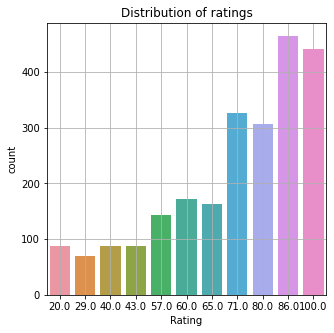

In [126]:
fig, ax = plt.subplots(figsize = (5, 5))
sns.countplot(data = df, x = 'Rating',
              ax = ax,
              label = 'counts')

ax.set_title('Distribution of ratings')
ax.grid(True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


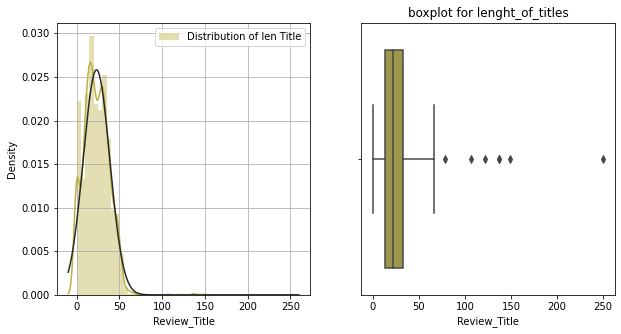

In [127]:
# -- maybe the better use Review_title and text together -- #
from scipy.stats import norm
length_of_titles = df.Review_Title.apply(lambda x: 0 if x is np.nan else len(x))
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
sns.distplot(a = length_of_titles,
             hist = True,
             ax = ax[0],
             label = 'Distribution of len Title',
             fit = norm,   
             color = '#BBB140'          
             )
ax[0].legend()
ax[0].grid()
sns.boxplot(x = length_of_titles, 
            color = '#AAA140', ax= ax[1],
            whis = 2.)

ax[1].set_title('boxplot for lenght_of_titles')

plt.show()

Feature extractions
Можно все эти признаки суммировать как для одного текста, а вдруг название и сам текст имеют немного разный смысл?

In [128]:
# -- Информация об отсутствии title возможно необходима -- #

# -- len -- #
df['total_length_title'] = df.Review_Title.apply(lambda x: 0 if x is np.nan else len(x))
df['total_length_text'] = df.Review_Text.apply(lambda x: 0 if x is np.nan else len(x))

# -- Number of capitalize -- #

# -- Before work with nan object for Title -- #
#df.Review_Title[df.Review_Title.isna()] = df.Review_Title[df.Review_Title.isna()].apply(lambda title: ' ')

df.Review_Title.apply(lambda x: type(x))
df['num_of_capitals_title'] = df.Review_Title.apply(lambda title: 
                                                    sum(1 for char in title if char.isupper()) if (title is not np.nan) else 0)

df['num_of_capitals_text'] = df.Review_Text.apply(lambda text: sum([1 for char in text if char.isupper()]))


# -- enter some new features -- #
eps = 0.1
df['caps_vs_length'] = df.apply(lambda row: float(row['num_of_capitals_title'])/float(row['total_length_title'] + eps), axis = 1)
# -- Вопрос. и воскл. знаки и препинания -- #
df['num_exclamation_marks_title'] = df.Review_Title.apply(lambda title: title.count('!') if title is not np.nan else 0)
df['num_exclamation_marks_text'] = df.Review_Text.apply(lambda text: text.count('!'))

df['num_quest_marks_title'] = df.Review_Title.apply(lambda title: title.count('?') if title is not np.nan else 0)
df['num_quest_marks_text'] = df.Review_Text.apply(lambda text: text.count('?'))

df['num_punctuation_title'] = df.Review_Title.apply(lambda title: sum(title.count(w) for w in '.,;:') if title is not np.nan else 0)
df['num_punctuation_text'] = df.Review_Text.apply(lambda text: sum(text.count(w) for w in '.,;:'))

# -- num words, num_unique words(locally) -- #
df['num_words_title'] = df.Review_Title.apply(lambda title: len(title.split()) if title is not np.nan else 0)
df['num_words_text'] = df.Review_Text.apply(lambda text: len(text.split()))

df['num_unique_words_title'] = df.Review_Title.apply(lambda title: len(set(w for w in title.split())) if title is not np.nan else 0)
df['num_unique_words_text'] = df.Review_Text.apply(lambda text: len(set(w for w in text.split())))

df['words_vs_unique_title'] = df['num_words_title']/(df['num_unique_words_title'] + eps)
df['words_vs_unique_text'] = df.apply(lambda row: float(row['num_words_text'])/(row['num_unique_words_text'] + eps), axis = 1)

# -- only text -- #
df['num_smilies'] = df.Review_Text.apply(lambda text: sum(text.count(w) for w in (':-)', ':)', ';-)', ';)')))

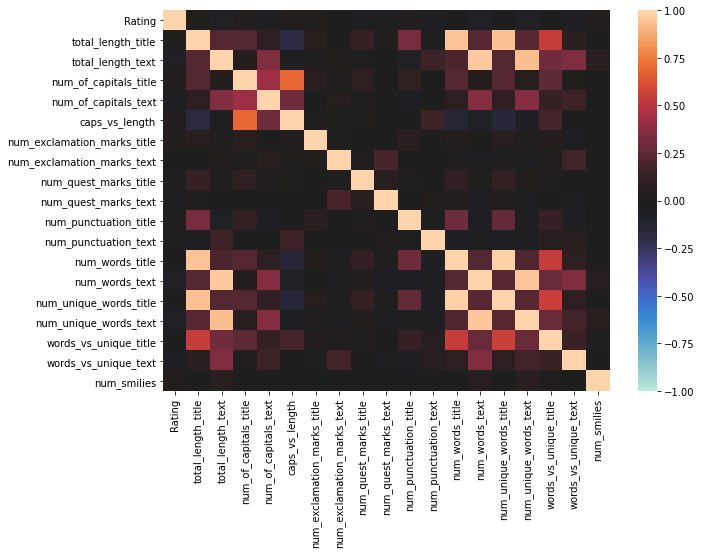

In [129]:
# -- lets see on correleations between new features -- #

fig, ax = plt.subplots(figsize = (10, 7))
correlations_matrix = df.drop(columns = [col for col in df.columns if col.find('Review') != -1]).corr()
ax = sns.heatmap(correlations_matrix, 
                 vmin = -1, 
                 vmax = 1, 
                 center = 0.)
plt.show()


Видно, что держать в таком виде наши данные просто безумие, проще title and text в один пихнуть, а потом добавть новые признаки на 

In [130]:
# -- try to remove some features with high covariance -- #
# -- names of hotels -- #
import string 
lengths_of_names = df_new.Hotel_name.apply(lambda x: len(x.split(' '))).value_counts()
if('ID' in set(df_new.columns)):
  df_new = df_new.drop(columns  = ['Id'])

# -- concat together Review Title and Review Text -- #
def concatTitleText(title, text):
  if(title is np.nan):
    return text
  else:
    return text + title

df_new['allText'] = df_new.apply(lambda r: concatTitleText(r['Review_Title'], r['Review_Text']), axis = 1)
# -- some check Titles with lower case -- #

not_nan = df_new.Review_Title.isna().values.astype(bool)
mask_lower_case = df_new.Review_Title[~not_nan].str[0].apply(lambda x: x.islower())


In [131]:
# -- the same preprocessing -- #
def AddFeaturesText(df_not_change, text_column :str):
  """
  get dataframe df_not_change and after we returned a new DataFrame of added Dataset 
  """
  # -- len -- #
  df = df_not_change.copy(deep = True)
  df['total_length_text'] = df[text_column].apply(lambda x: 0 if x is np.nan else len(x))
  # -- Number of capitalize -- #
  
  df['num_of_capitals_text'] = df[text_column].apply(lambda text: sum([1 for char in text if char.isupper()]))
  # -- enter some new features -- #
  
  eps = 0.1
  df['caps_vs_length'] = df.apply(lambda row: float(row['num_of_capitals_text'])/float(row['total_length_text'] + eps), axis = 1)
  # -- Вопрос. и воскл. знаки и препинания -- #

  df['num_exclamation_marks_text'] = df[text_column].apply(lambda text: text.count('!'))
  df['num_quest_marks_text'] = df[text_column].apply(lambda text: text.count('?'))
  df['num_punctuation_text'] = df[text_column].apply(lambda text: sum(text.count(w) for w in '.,;:'))

  # -- num words, num_unique words(locally) -- #
  df['num_words_text'] = df[text_column].apply(lambda text: len(text.split()))
  df['num_unique_words_text'] = df[text_column].apply(lambda text: len(set(w for w in text.split())))
  df['words_vs_unique_text'] = df.apply(lambda row: float(row['num_words_text'])/(row['num_unique_words_text'] + eps), axis = 1)

  # -- only text -- #
  df['num_smilies'] = df[text_column].apply(lambda text: sum(text.count(w) for w in (':-)', ':)', ';-)', ';)')))
  return df

df_new_add = AddFeaturesText(df_new, 'allText')

In [132]:
import nltk 
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
from collections import Counter
import re

nltk.download('stopwords')
nltk.download('punkt')
stopwords_ = set(stopwords.words('english'))
punctuations_letters = string.punctuation

def removepunctuations(text):
  return text.translate(str.maketrans('', '', punctuations_letters))

def removespecialletterscomplex(text):
  """
  We need not concat in place of special symbols 
  """
  for word in text.split(" "):
    for char in word:
      if not char.isalpha():
        print([word], ' ', [char])

def removePunctSpecial(text):
  """
  remove Punctuations and Other character 
  """
  tokens = word_tokenize(text)
  words = [word for word in tokens if word.isalpha()]
  return " ".join(words)

def removespecialletters(text):
  """
  remove special letters from text 
  we just remove our \n and concatenete words together 
  """
  words = text.split(" ")
  return ' '.join([''.join([char for char in word if char.isalpha()]) for word in words])

def removingstopwords(text):
  """
  remove from text all stopwords of English language
  """
  if(stopwords_ is None):
    print('We need download stopwords of English language')
  words = text.split(" ")
  return " ".join([word for word in words if word not in set(stopwords_)])

def returnFrequentList(df, col_name_text):
  """
  return Counter of all words in dataset frequent vocabulary
  """
  cnt = Counter()
  for row in df.itertuples(index = True, name = 'Pandas'):
    text_current = getattr(row, col_name_text) 
    tokenize = word_tokenize(text_current)
    for word in tokenize:
      cnt[word] += 1
  return cnt 

# -- the better made lemmatization -- # 
# -- it's more complex and stable for noise data -- #
def stemmedtext(text):
  """
  stemming 
  """
  porter = PorterStemmer()
  tokens = word_tokenize(text)
  stemmed = [porter.stem(word) for word in tokens]
  return ' '.join(stemmed)

def preprocessingStandartText(df, text_column):
  """
  get DataFrame and made simple text Preprocessing (removal punctuations,
  lower case, remove rare words and etc)
  return a new dataset with preprocessed Text representetion
  """
  df_copy = df.copy(deep = True)
  # -- lower -- #
  df_copy[text_column] = df_copy[text_column].str.lower()
  # -- remove punctuations and special cases -- #
  df_copy[text_column] = df_copy[text_column].apply(lambda text: removePunctSpecial(text))
  # -- remove stop words -- #
  df_copy[text_column] = df_copy[text_column].apply(lambda text: removingstopwords(text))
  # -- stemming -- #
  df_copy[text_column] = df_copy[text_column].apply(lambda text: stemmedtext(text))
  # -- remove rare and very frequent words -- #
  return df_copy

# -- lower case -- #
df_new_add['allText'] = df_new_add['allText'].str.lower()

# -- NLTK -- #
df_new_add['allText_diff'] = df_new_add['allText'].apply(lambda text: removePunctSpecial(text))

# -- removal punctuations -- #

text = df_new_add.allText[3]
after_text = text.translate(str.maketrans('', '', punctuations_letters))
after_text, text

df_new_add['allTextNoPunct'] = df_new_add['allText'].apply(lambda text: removepunctuations(text))

# -- remove special characters and numbers -- #
df_new_add['allTextNoPunct'] = df_new_add['allTextNoPunct'].apply(lambda text: removespecialletters(text))
df_new_add.allTextNoPunct

# -- removal stopwords -- #

# -- we just see on example -- #
text_id = np.random.choice(df_new_add.index, size = 1)[0]
text = df_new_add.loc[text_id, 'allTextNoPunct']
print('-'*50)
print('Text before: \n{}'.format(text))
stop_words = []
new_text = []
for idx, word in enumerate(text.split(" "), 0):
  if word in set(stopwords_):
    #print('stop word: {}'.format(word))
    stop_words.append(word)
  else:
    new_text.append(word)

new_text = " ".join(new_text)
after_text = removingstopwords(text)

print('-'*50)
print('after text: \n{}'.format(new_text))
print('-'*50)
print('stop words: \n{}'.format(stop_words))

# -- removing stopwords -- #
df_new_add.allTextNoPunct = df_new_add.allTextNoPunct.apply(lambda text: removingstopwords(text))
# -- removing stopwords in another (good) variant -- #
df_new_add['allText_diff'] = df_new_add['allText_diff'].apply(lambda text: removingstopwords(text))

# -- removing frequent words -- #
# -- На самом деле это не нужно делать, если у нас tf-idf, так как такая векторизация слов учтёт частотные характеристики слов -- #
# -- Частотный словарь -- #
cnt = Counter()

text_column_name = 'allTextNoPunct' 
for row in df_new_add.itertuples(index = True, name = "Pandas"):
  text_current = getattr(row, text_column_name)
  words = text_current.split(" ")
  for w in words:
    cnt[w] += 1

print('-'*50)
cnt.most_common(20)
# -- Не кажеться мне, что стоит удалять данные слова, так как они достаточно информативны -- #

# -- The same we can drop a rare words from our text -- #

num_rare_words = 10
rare_words = set([w for w, f in cnt.most_common(cnt.values().__len__())[-num_rare_words:]])
#rare_words

# -- new clear data -- #
counter_ = returnFrequentList(df_new_add, 'allText_diff')
rare_words_2 = set([w for w, f in counter_.most_common(counter_.values().__len__())[-num_rare_words:]])
print('Rare words: {}\n'.format(num_rare_words))
print(rare_words_2)

# -- stemming -- #
porter = PorterStemmer()
tokens = word_tokenize(df_new_add.allText_diff[1])
stemmed = [porter.stem(word) for word in tokens]
stemmed

df_new_add['allText_diff'] = df_new_add['allText_diff'].apply(lambda text: stemmedtext(text))
df_new_add.allText_diff[5]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
--------------------------------------------------
Text before: 
very close to railway station nice hospitality easy to approach shopping malls staff very kind food was excellent complimentary breakfast very good next visit prefer to stay in same hotel nice location room maintained wellexcellent stay
--------------------------------------------------
after text: 
close railway station nice hospitality easy approach shopping malls staff kind food excellent complimentary breakfast good next visit prefer stay hotel nice location room maintained wellexcellent stay
--------------------------------------------------
stop words: 
['very', 'to', 'to', 'very', 'was', 'very', 'to', 'in', 'same']
--------------------------------------------------
Rare words: 10

{'traces

'reach hotel car felt good offic staff room servic late hotel atmospher good food drink avail hotel nice experi visit hotel enjoy lot friend also happi atmospher food drink avail'

На самом деле мы видим много информации в слипшихся словах. Наш текст очень грязный, поэтому необходимо что-то сделать с слипшимися словами?


In [133]:
from numpy.linalg import norm
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

corpus_train = df_new_add['allText_diff']
tf_idf = TfidfVectorizer()
# -- create a normolized tf-idf vectors -- #
corpus_tfidf = tf_idf.fit_transform(corpus_train)

# -- check our vocabulary of tfidf -- #
vocabulary = tf_idf.vocabulary_
counter_vocab = returnFrequentList(df_new_add, 'allText_diff')

# -- see on lenght of words -- #
wordLen = np.array([[word, len(word)] for word, counts in counter_vocab.items()])
wordCount = np.array([[word, counts] for word, counts in counter_vocab.items()])
wordLenSort = wordLen[np.array(wordLen[:, 1], dtype = np.int).argsort()][::-1]
# -- we need drop this words or documents -- #
bad_words = wordLenSort[(np.array(wordLenSort[:, 1], dtype = int) >= 50)][:, 0]

# -- find this words in dataset -- #
badIndeces = set()
for row in df_new_add.itertuples():

  text = getattr(row, 'allText_diff')
  id = getattr(row, 'Index')
  for bad_word in bad_words:
    if(len(re.findall(bad_word, text)) != 0):
      badIndeces.add(id)

# -- see on bad document in all corpus -- #
print('Number of documents with bad words (len more then 50 symbols): {}'.format(badIndeces.__len__()))
print('Rating of this documents : \n')
print(df_new_add.loc[list(badIndeces), ['Rating']].values)

# -- see on counts bad words ( together with another words ) -- #
for idx, w in enumerate(wordLenSort[:50, 0], 1):
  print(w, " counts: ", counter_vocab[w])

# -- по идее стоит выкинуть из словаря слова с > 50 длинной -- #
# -- А также есть множество слипшихся отдельных слов от 2-3 -- #

Number of documents with bad words (len more then 50 symbols): 10
Rating of this documents : 

[[65.]
 [65.]
 [65.]
 [65.]
 [65.]
 [65.]
 [65.]
 [65.]
 [71.]
 [65.]]
vfdsfsdfgdgdsgsdgsdddddddgfggfjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjv  counts:  1
hajajshshhsksbsjnsdbjsbjshjbdhdkdndndjdbxjdkdjdddkkddjdddnddjdgskhsdjdidhskndjdbdjdbkddnkdndjdbdkdndnfjfbdndkdndkdndkdndkdnfjdjdnfkdndjfjkdbdkfhkdndkdbkddnddkdjdnfjfjdndkdndhjddjkdjdhdkdnbddndbdjdjjdkdndjgood  counts:  1
nbnnnhhhgttdcvjuytdvjkiffjjydvhuthjhbjjgfbhjufcbjhfvjbjfbjbijtcbniasfjkltewwsfjjjkkytrwwfhjkkkooyreewadhknvcxzcvnmccccbbcxxbncxbbnkkgfdjhgggggggggupuyyrrrdeddghklllmccddwetyjoiuurrrrwwdhjjjkkiytrrrfhjgtbjhjj  counts:  1
fflhlxoxoxitxtxttcolgtcoxgxtixkrxrxfllxdridxfizgxoxixxtoxothcgchochcypyfcycoycyycyycpufotdtodtodotxyycpycyxpgxgpxyoxtoxp

In [134]:
df_test = pd.read_csv('/content/data/nlp/test.csv', encoding='ISO-8859-1')
print('size of test: {}\nsize of train: {}'.format(df_test.shape[0],
                                                   df_new_add.shape[0]))


def dropColumns(df, columns: list):
  for col in columns:
    if col in set(df.columns):
      df.drop(columns = [col], inplace = True)
  return df

# -- divided dataset in middle -- #
df_test['allText'] = df_test.apply(lambda r: concatTitleText(r['Review_Title'], r['Review_Text']), axis = 1)
df_test_add = AddFeaturesText(df_test, 'allText')
df_test_prep = preprocessingStandartText(df_test_add, 'allText')

# -- delete Review Title and Text and Id -- #
drop_test_df = ['Id', 
                'Review_Title', 
                'Review_Text']

df_test_prep = dropColumns(df_test_prep, drop_test_df)

"""if('Review_Title' in set(df_test_prep.columns)):
  df_test_prep.drop(columns = ['Review_Title'])

if('Review_Text' in set(df_test_prep.columns)):
  df_test_prep.drop(columns = ['Review_Text'])

if('Id' in set(df_test_prep.columns)):
  df_test_prep.drop(columns = ['Id'])
"""
drop_train_df = ['Id', 
                'Review_Title', 
                'Review_Text', 
                'allText',
                'allTextNoPunct']

df_new_add = dropColumns(df_new_add, drop_train_df)
df_new_add.rename(columns = {'allText_diff': 'allText'}, inplace = True)
# -- we can use information of stats for name of Hotels -- #

size of test: 2352
size of train: 2351


In [135]:

def fillMedianRaiting(row, 
                      hotelStatsRating, 
                      isTest = False):
  try:
    if isTest:
      # -- in dataset -- #
      if(hotelStatsRating.to_dict()['median'].get(str(row['Hotel_name'])) != -1):
        return hotelStatsRating.to_dict()['median'][str(row['Hotel_name'])]
      else:
      # -- not in dataset -- #
        return np.nan
    else:
      return hotelStatsRating.to_dict()['median'][str(row['Hotel_name'])]
  except KeyError:
    print("Error on : {}".format(row['Hotel_name']))
  
hotelStatsTrain = df_new_add.groupby(by = ['Hotel_name'])['Rating'].agg(['median', 
                                                                         'count']).sort_values(by = ['count'],
                                                                             ascending = False)
# -- fill all Train Examples -- #                                                                        
df_new_add['medianRating'] = df_new_add.apply(lambda r: fillMedianRaiting(r, 
                                                                          hotelStatsTrain, 
                                                                          isTest = False), axis = 1)
# -- fill all Test Examples -- #
df_test_prep['medianRating'] = df_test_prep.apply(lambda r: fillMedianRaiting(r, 
                                                                              hotelStatsTrain, 
                                                                              isTest = True), axis = 1)

print('We have: {} Nan objects in Test We fill it median of all column'.format(df_test_prep.medianRating.isna().sum()))
df_test_prep.medianRating.fillna(np.median(df_new_add.medianRating.values), inplace = True)
# -- check -- #
assert(df_test_prep.medianRating.isna().sum() == 0)

Error on : Treebo Nestlay Airport
Error on : Deshna Home Stay -Arumbakkam
Error on : Regency Tiruttani by GRT Hotels
Error on : Ngh Transit
Error on : Dream Inn-Omr
Error on : Ngh Transit
Error on : Balaji Resort
Error on : Greens
Error on : Samrat Guest House
Error on : Frangi House
Error on : Frangi House
Error on : V7
Error on : Balaji Resort
Error on : Treebo Nestlay Airport
Error on : Nakshatra Serviced Apartment - Teynampet
Error on : Pebbles
Error on : Frangi House
Error on : Regency Tiruttani by GRT Hotels
Error on : Frangi House
Error on : Ngh Transit
Error on : Sai Enclave Residency
Error on : Frangi House
Error on : Dream Inn-Omr
We have: 23 Nan objects in Test We fill it median of all column


In [137]:
# -- train model LinearRegression task -- #

In [186]:
from scipy.sparse import hstack
from sklearn.linear_model import Ridge, SGDRegressor, Lasso, LinearRegression,SGDClassifier, LogisticRegression
                                
# -- train our models -- #
tfidf = TfidfVectorizer()
corpus_train = df_new_add.allText
corpus_test = df_test_prep.allText
corpus_train_vec = tfidf.fit_transform(corpus_train)
corpus_test_vec = tfidf.transform(corpus_test)

# -- we shuld concat all data in one dataframe -- #
y_train = df_new_add.Rating.values
X_feature_train = df_new_add.loc[:, list(set(df_new_add.columns).difference(['Rating', 
                                                                             'allText', 
                                                                             'Hotel_name']))]

X_feature_test = df_test_prep.loc[:, list(set(df_test_prep.columns).difference(['allText', 
                                                                                'Hotel_name']))]

# -- stack all data in one sparse matrix -- #
X_train = hstack((X_feature_train, corpus_train_vec), format = 'csr')
X_test = hstack((X_feature_test, corpus_test_vec), format = 'csr')
# -- check dimensions -- #
assert(X_test.shape[1] ==  X_train.shape[1])

In [236]:
from sklearn.model_selection import train_test_split
# -- train model -- #
# -- Linear Regressions -- #

# -- choose SEED -- #
SEED = 42
np.random.seed(SEED)
# -- choose test_size -- #
test_size = 0.3
# -- load all dataset -- #
df_all = pd.read_csv("/content/data/nlp/train.csv", encoding='ISO-8859-1')
# -- shuffle dataset -- #
indeces = df_all.index.tolist()
np.random.shuffle(indeces)
df_all = df_all.loc[indeces, :]
split_index = int(df_all.shape[0] * (1 - test_size))
# -- create train and test data -- #
df_train = df_all.iloc[: split_index, :]
df_test = df_all.iloc[split_index : , :]

# -- check sizes of data -- #
assert(df_train.shape[0] + df_test.shape[0] == df_all.shape[0])

# -- drop Target in test data -- #
y_test = df_test['Rating']
# -- preprocessing and Feature Extraction -- #
# -- concat Title and Text -- #
df_train['allText'] = df_train.apply(lambda r: concatTitleText(r['Review_Title'],
                                                                r['Review_Text']), axis = 1)

df_test['allText'] = df_test.apply(lambda r: concatTitleText(r['Review_Title'],
                                                                r['Review_Text']), axis = 1)

# -- create new features on dirty data text -- #
df_train = AddFeaturesText(df_train, text_column = 'allText')
df_test = AddFeaturesText(df_test, text_column = 'allText')

# -- preprocessing our text data from dirty to clean -- #
df_train = preprocessingStandartText(df_train, text_column = 'allText')
df_test = preprocessingStandartText(df_test, text_column = 'allText')

# -- create new feature of StatsRaiting -- #
# -- create stats -- #
hotelStatsTrain = df_train.groupby(by = ['Hotel_name'])['Rating'].agg(['median', 
                                                                       'count']).sort_values(by = ['count'],
                                                                                             ascending = False)
# -- fill all Train Examples -- #
df_train['medianRating'] = df_train.apply(lambda r: fillMedianRaiting(r, 
                                                                      hotelStatsTrain, 
                                                                      isTest = False), axis = 1)
# -- fill all Test Examples -- #
df_test['medianRating'] = df_test.apply(lambda r: fillMedianRaiting(r, 
                                                                    hotelStatsTrain, 
                                                                    isTest = True), axis = 1)

print('We have: {} Nan objects in Test We fill it median of all column'.format(df_test.medianRating.isna().sum()))
# -- fill nan oblect just median values from train dataset -- #
df_test.medianRating.fillna(np.median(df_train.medianRating.values), inplace = True)
# -- check na objects in test -- #
assert(df_test.medianRating.isna().sum() == 0)

# -- drop some columns -- #
df_train.columns, df_test.columns 
drop_columns_train = ['Id', 
                'Hotel_name', 
                'Review_Title', 
                'Review_Text', 
                ]

drop_columns_test = ['Id', 
                     'Hotel_name', 
                     'Review_Title', 
                     'Review_Text', 
                     'Rating',
                    ]

df_train = dropColumns(df_train, drop_columns_train)
df_test = dropColumns(df_test, drop_columns_test)
# -- end prepare data -- #

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Error on : Vestin Park
Error on : Stay Easy Serviced Apartments Sholinganalur
Error on : The Chamiers Park
Error on : Oyo Apartments Guduvanchery Srm University
Error on : Oriental Inn
Error on : Shylee Niwas Kodambakkam I
Error on : Lloyds Guest House
Error on : Lloyds Guest House
Error on : Leisure Stays
Error on : Melody
Error on : Oriental Inn
We have: 11 Nan objects in Test We fill it median of all column


In [264]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
# -- create target -- #
# -- tfidfVectorized -- #
from sklearn.feature_extraction.text import CountVectorizer
# -- What different (Vectorized and Transformer)
tfidf = TfidfVectorizer()
countvec = CountVectorizer()

#tfidf = TfidfTransformer(smooth_idf = True)
corpus_train = df_train.allText
corpus_test = df_test.allText
corpus_train_vec = tfidf.fit_transform(corpus_train)
corpus_test_vec = tfidf.transform(corpus_test)

corpus_train_count_vec = countvec.fit_transform(corpus_train)
corpus_test_count_vec = countvec.transform(corpus_test)

# -- we shuld concat all data in one dataframe -- #
y_train = df_train['Rating']
stay_columns = ['medianRating']

"""
    Text and RaitingStats
"""

"""
std = StandardScaler()

X_feature_train = df_train.loc[:, stay_columns]
X_feature_test = df_test.loc[:, stay_columns]

X_feature_train_arr = std.fit_transform(X_feature_train)
X_feature_test_arr = std.transform(X_feature_test)
"""


"""
    Many things
"""
"""
col_unique = [col for col in df_train.columns if col.find('unique') != -1]
# -- drop cols with unique (Very correlated) -- #

std = StandardScaler()
X_feature_train = df_train.loc[:, list(set(df_train.columns).difference(['Rating', 
                                                                         'allText', 
                                                                         'Hotel_name']))]

X_feature_test = df_test.loc[:, list(set(df_test.columns).difference(['allText', 
                                                                      'Hotel_name']))]

X_feature_train_arr = std.fit_transform(X_feature_train)
X_feature_test_arr = std.transform(X_feature_test)

"""
# -- stack all data in one sparse matrix -- #
#"""
X_train = hstack((X_feature_train, corpus_train_vec), format = 'csr')
X_test = hstack((X_feature_test, corpus_test_vec), format = 'csr')
#"""
"""
    Only text
"""
# -- Только текст -- #
#"""
X_train = corpus_train_count_vec
X_test = corpus_test_count_vec
#"""
# -- check dimensions -- #
assert(X_test.shape[1] ==  X_train.shape[1])

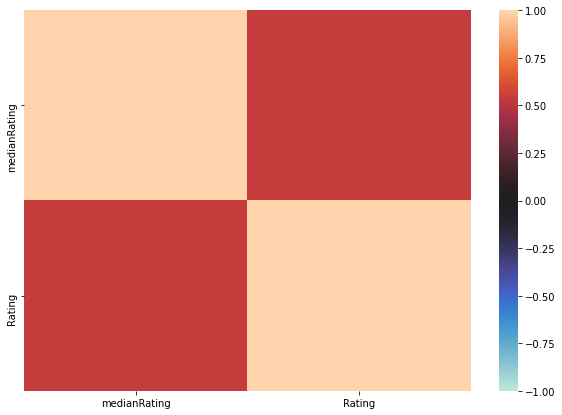

In [265]:
df_train_no_text = pd.concat([X_feature_train, y_train], axis = 1)
fig, ax = plt.subplots(figsize = (10, 7))
correlations_matrix = df_train_no_text.corr()
ax = sns.heatmap(correlations_matrix, 
                 vmin = -1, 
                 vmax = 1, 
                 center = 0.)
plt.show()

In [270]:
# -- train data -- #
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, ComplementNB 

#std = StandardScaler()
#X_train = std.fit_transform(X_train)
#X_test = std.transform(X_test)

param_grid_sgd = {
    'alpha' : np.logspace(-4, 3, 10),
}
param_grid_logreg = {
    'C' : np.logspace(-4, 3, 10),
}

sgd = SGDClassifier(max_iter = 10000)
svm = SVC()
#logreg = LogisticRegression(solver = 'sag')

kf = KFold(5, shuffle = True)
"""
    Grid for SGD
"""


grid = GridSearchCV(sgd, 
                    param_grid = param_grid_sgd, 
                    cv = kf)

"""
    SVC Grid
"""
"""
grid = GridSearchCV(svm, 
                    param_grid = param_grid_logreg, 
                    cv = kf)
"""
"""
    Grid for Logistic Regr
"""
"""
grid = GridSearchCV(logreg, 
                    param_grid = param_grid_logreg, 
                    cv = kf)
"""
grid.fit(X_train, y_train)
y_pred = grid.best_estimator_.predict(X_test)

print('rmse: {}'.format(mean_squared_error(y_test, y_pred, squared = False)))

rmse: 17.146386895477576


Лучшая модель, это MultinomialNB

In [271]:
# -- Maybe should be CountVectorized -- #

NB_com = MultinomialNB()
param_grid_com_NB = {
    'alpha' : np.linspace(0.001, 1., 100),
}
grid = GridSearchCV(NB_com, 
                    param_grid = param_grid_com_NB, 
                    cv = kf)
grid.fit(X_train, y_train)
y_pred = grid.best_estimator_.predict(X_test)

print('rmse on ComplementNB: {}'.format(mean_squared_error(y_test, y_pred, squared = False)))

rmse on ComplementNB: 16.623986901760812


### В качестве улучшения, можно попробовать взять Lemmatization. Представлять word2vec - для текста. И лучше чистить и нормализовывать данные текста.

In [273]:
# -- Maybe should be CountVectorized -- #

NB = ComplementNB()
param_grid_NB = {
    'alpha' : np.linspace(0.001, 1., 100),
}
grid = GridSearchCV(NB, 
                    param_grid = param_grid_NB, 
                    cv = kf)
grid.fit(X_train, y_train)
y_pred = grid.best_estimator_.predict(X_test)

print('rmse on ComplementMultinomial: {}'.format(mean_squared_error(y_test, y_pred, squared = False)))

rmse on ComplementMultinomial: 18.488722540776084


In [263]:
grid.best_params_

{'alpha': 0.011090909090909092}

Вообще говоря стоит делать предобработку данных на чистом датасете, когда у нас уже отсутствует лишняя информация. 

In [182]:
pd.read_csv("/content/data/nlp/test.csv", encoding='ISO-8859-1').columns

Index(['Id', 'Hotel_name', 'Review_Title', 'Review_Text'], dtype='object')

In [140]:
# -- we have some slahes -- #

def isHaveSlashesFind(text):
  if "\\" in r"%r" % text:
    return True
  else:
    return False 

#removespecialletters(text)
# -- a little bit more learn about backslashes -- #
print("Number objects in data, which have backslashes: \
  {} All numbers of objects: {}".format(df_new_add.allText.apply(lambda x: isHaveSlashesFind(x)).sum(),
                                                    df_new_add.shape[0]))


mask_isslashes = df_new_add.allText.apply(lambda x: isHaveSlashesFind(x))
times = 0
special_symbols_slashes = set()
for row in df_new_add[mask_isslashes].itertuples(index = True, name = 'Pandas'):
  list_current = re.findall(r'\\\w', r"%r" % getattr(row, 'allTextNoPunct'))
  [special_symbols_slashes.add(chars) for chars in list_finds]

print('special symbols with slashes: ')
[print(s) for s in special_symbols_slashes];

Number objects in data, which have backslashes:   0 All numbers of objects: 2351
special symbols with slashes: 


In [21]:
! pip install langdetect

     |████████████████████████████████| 983kB 15.4MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp37-none-any.whl size=993193 sha256=fd6837481ed241febe58f0d82867f3fab27cf8d9fa3ae55bfcebe96f8e6a60ee
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


In [22]:
# -- detect language -- #
from langdetect import detect
def detectLanguage(text):
  """
  We want to detect language
  """
  try:
    code = detect(text)
    return code
  except: 
    print('Error: ')
    print(text)
    return np.nan

codesOfLanguage = df_new_add.allTextNoPunct.apply(lambda text: detectLanguage(text))

Error: 
 
Error: 

Error: 



Весь текст - английский, поэтому можем использовать stopwords for English sentence


In [173]:
df_new_add.allTextNoPunct[(codesOfLanguage == np.nan)]
assert(codesOfLanguage.shape[0] == df_new_add.shape[0])

True